# Driftscan FFI analysis -- `astrometry.net`

Michael Gully-Santiago  
May 16, 2018

This notebook follows a tutorial from [sep](http://sep.readthedocs.io/), maintained by Kyle Barbary.

The goal of this notebook is to quantify the driftscan FFI motion.

In [1]:
import numpy as np
import sep
import pandas as pd

In [2]:
# additional setup for reading the test image and displaying plots
import fitsio
import matplotlib.pyplot as plt
from matplotlib import rcParams

%matplotlib inline

rcParams['figure.figsize'] = [10., 8.]

We'll add some custom tools:

In [3]:
import sys
import os
sys.path.append(os.path.abspath("../code/"))
import ffi_tools

I have the data saved locally for now.  Kepler channels have four distinct orientations on the sky (separated by 90$^\circ$ rotations from each other.  For example, in [FFI images](https://keplerscience.arc.nasa.gov/images/release-notes/c6/spica.png) you can see that certain saturated stars have their bleed columns pointing in orthogonal directions-- some go up, and some go down.  Some are also "upside down" relative to others.


For simplicity let's just focus on channels possessing the same orientation.  Thankfully, Christina Hedges identified these already!

In [4]:
ch_set_I = np.array([13,33,53,37,57,41,27,31,47,51,71])
ch = ch_set_I[2]

In [5]:
# read image into standard 2-d numpy array
data = fitsio.read("../data/C17_driftscans/ffi-kacr2120/kplr2018131032646_ffi-orig.fits", ext=ch)

Preprocess the fits file by trimming off the edges.

In [6]:
data = ffi_tools.preprocess_dFFI(data) 
sx, sy = data.shape

Show a quick plot of the preprocessed image.

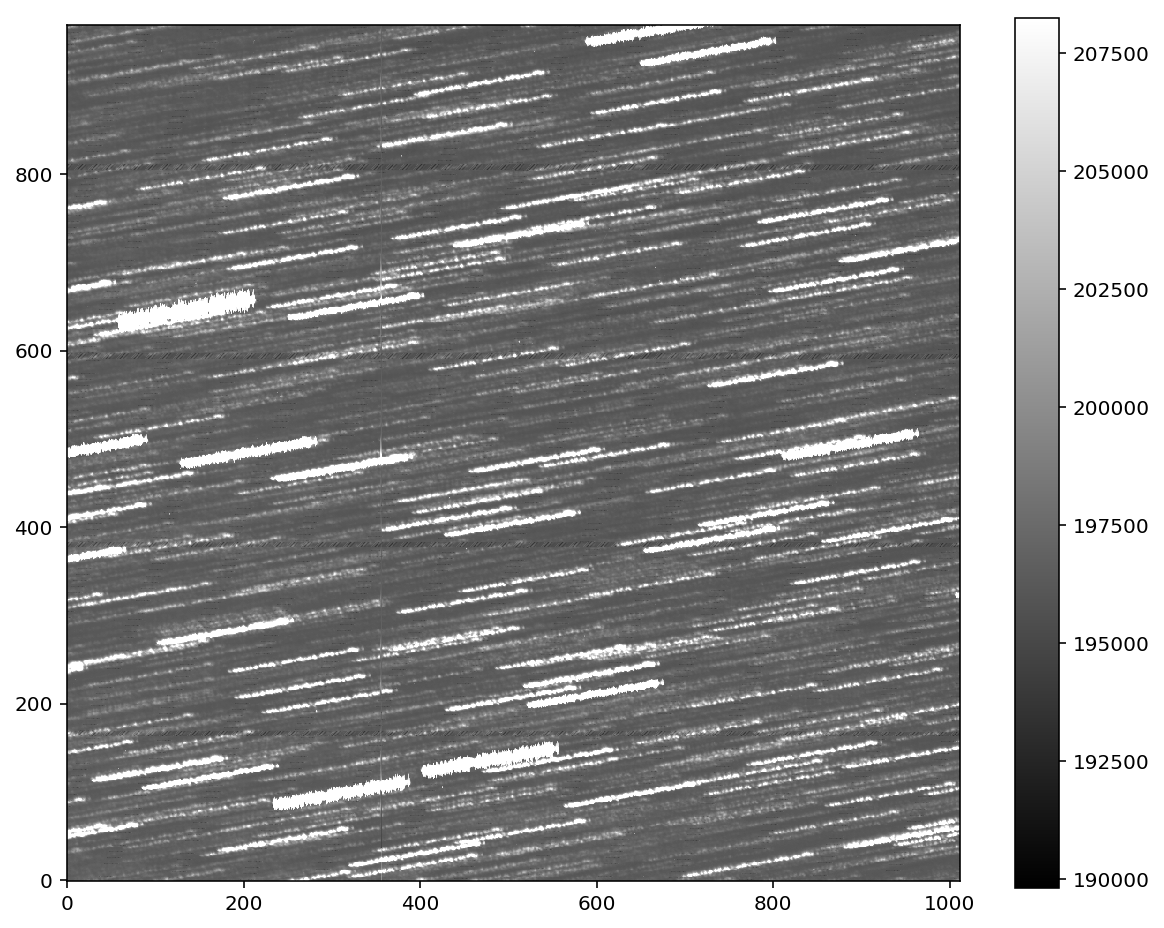

In [7]:
ffi_tools.quick_plot(data)

Background subtract

In [8]:
data_sub, bkg = ffi_tools.background_subtract(data, return_bkg=True)

## Object detection

Now that we've subtracted the background, we can run object detection on the background-subtracted data. You can see the background noise level is pretty flat. So here we're setting the detection threshold to be a constant value of $1.5 \sigma$ where $\sigma$ is the global background RMS.

In [9]:
kernel = ffi_tools.get_kernel()

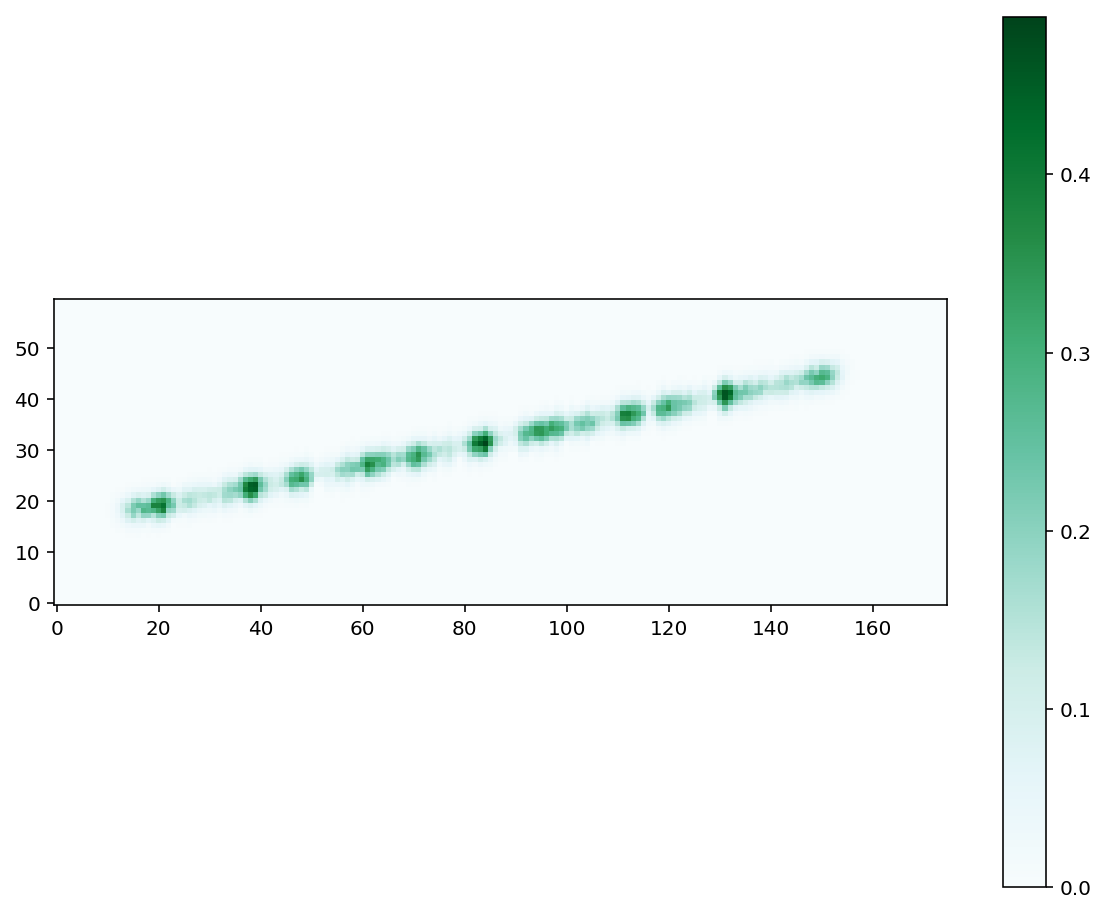

In [10]:
ffi_tools.plot_kernel(kernel)

### Source extraction with the kernel.

In [11]:
objects = sep.extract(data_sub, 4.0, filter_kernel=kernel,  err=bkg.globalrms)

In [12]:
df_objects = pd.DataFrame(objects)

In [13]:
df_objects.shape # N_objects x n_columns

(113, 30)

In [14]:
df_objects.head()

,thresh,npix,tnpix,xmin,xmax,ymin,ymax,x,y,x2,...,cxy,cflux,flux,cpeak,peak,xcpeak,ycpeak,xpeak,ypeak,flag
0,2614.127441,1923,1143,131,366,22,67,249.532121,44.713283,2658.321898,...,-0.074270,12034887.0,13285805.0,13931.250977,49018.0,244,44,268,50,0
1,2614.127441,3869,2374,679,1011,0,69,903.363112,39.541002,6317.731941,...,-0.026640,28045710.0,32881872.0,21713.812500,82498.0,953,48,977,54,2
2,2614.127441,1936,1065,294,607,0,49,405.968696,16.883767,5443.095232,...,-0.078642,8466227.0,9781494.0,9154.208008,39655.0,391,14,415,20,3
3,2614.127441,3729,1935,259,638,0,77,430.491441,35.251912,6974.109697,...,-0.063144,29794898.0,31499270.0,21772.044922,84106.0,405,30,417,33,3
4,2614.127441,543,253,361,504,33,59,430.749340,45.752703,1154.838351,...,-0.262353,1802667.5,1788589.0,4516.735840,16875.0,426,45,444,50,1


In [15]:
#df_objects.iloc[0]

`objects['x']` and `objects['y']` will give the centroid coordinates of the objects.

We know that some objects exhibit poor fits.  Let's filter the objects based on their metadata.
- Rotation angles should be close to 10 degrees.
- The semi-minor axes should be small; large semi-minor axes are indicative of saturated stars.

In [16]:
#plt.hist(objects['theta']* 180. / np.pi, bins=np.arange(0, 30, 1));
#plt.hist(objects['b'], bins=np.arange(0, 30, 1));

In [17]:
ny, nx = kernel.shape

In [18]:
poor_fits = ( ((objects['theta']* 180. / np.pi) > 20) |
              (objects['b'] > 15.0) |
              (objects['x'] < (nx/2 + 2)) | 
              (objects['x'] > ( sx - nx/2 - 2)) |
              (objects['y'] < (ny/2 + 2)) |  
              (objects['y'] > ( sy - ny/2 - 2)) )

In [19]:
saturated_mask = (objects['b'] > 5.0) & ~poor_fits

In [20]:
from matplotlib.patches import Rectangle

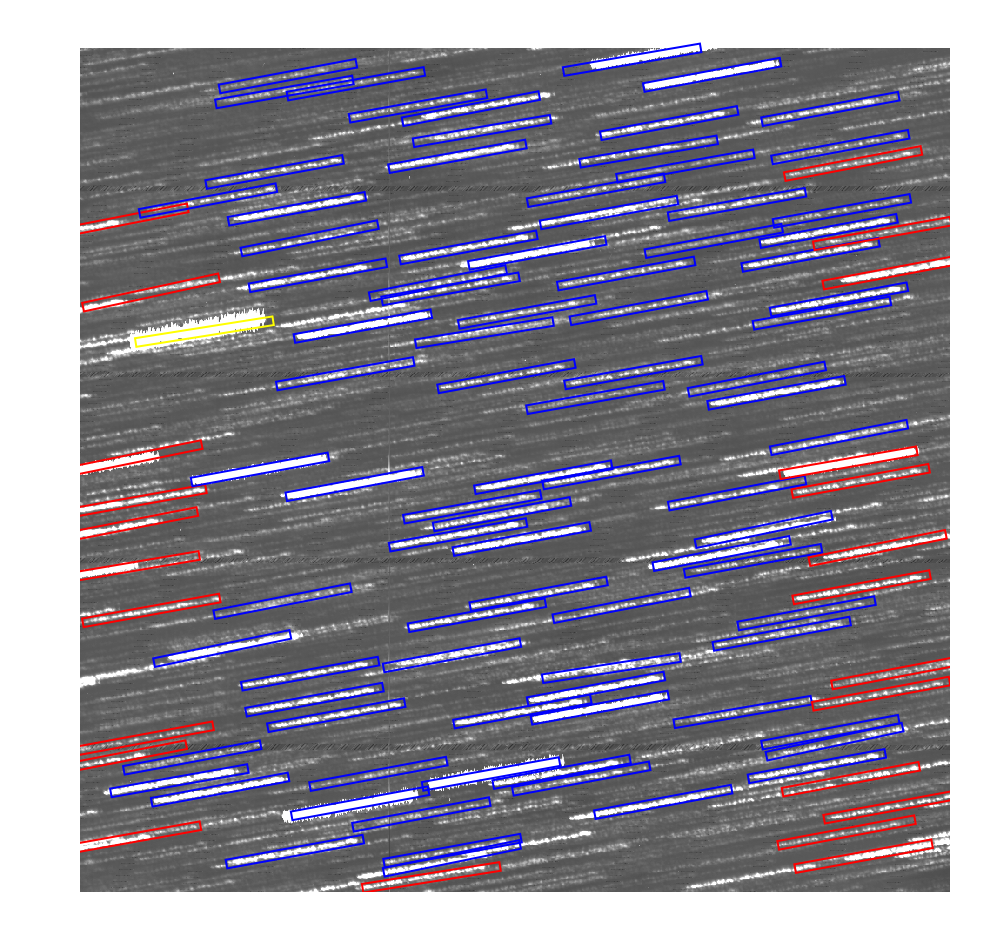

In [21]:
# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    if poor_fits[i]:
        color = 'red'
    elif saturated_mask[i]:
        color = 'yellow'
    else:
        color = 'blue'
    e = Rectangle(xy=(objects['x'][i]-80, objects['y'][i]-18),
                width=160,
                height=10,
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor(color)
    ax.add_artist(e)
    
plt.xlim(0, 1000)
plt.ylim(0, 1000)
plt.axis('off')
plt.savefig('../figures/astrometry_trial_02_og.png')

In [22]:
gi = ~poor_fits & ~saturated_mask
df_cln = df_objects[gi].reset_index(drop=True)

Make a star kernel.

In [23]:
m, s = np.mean(data_sub), np.std(data_sub)
dw = 10

In [24]:
from scipy.stats import multivariate_normal

In [25]:
x, y = np.mgrid[-dw:dw:1, -dw:dw:1]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
rv = multivariate_normal([0.0, 0.0], [[2.0, 0.3], [0.3, 2.2]])
star_kernel = rv.pdf(pos)

#plt.contourf(x, y, star_kernel)

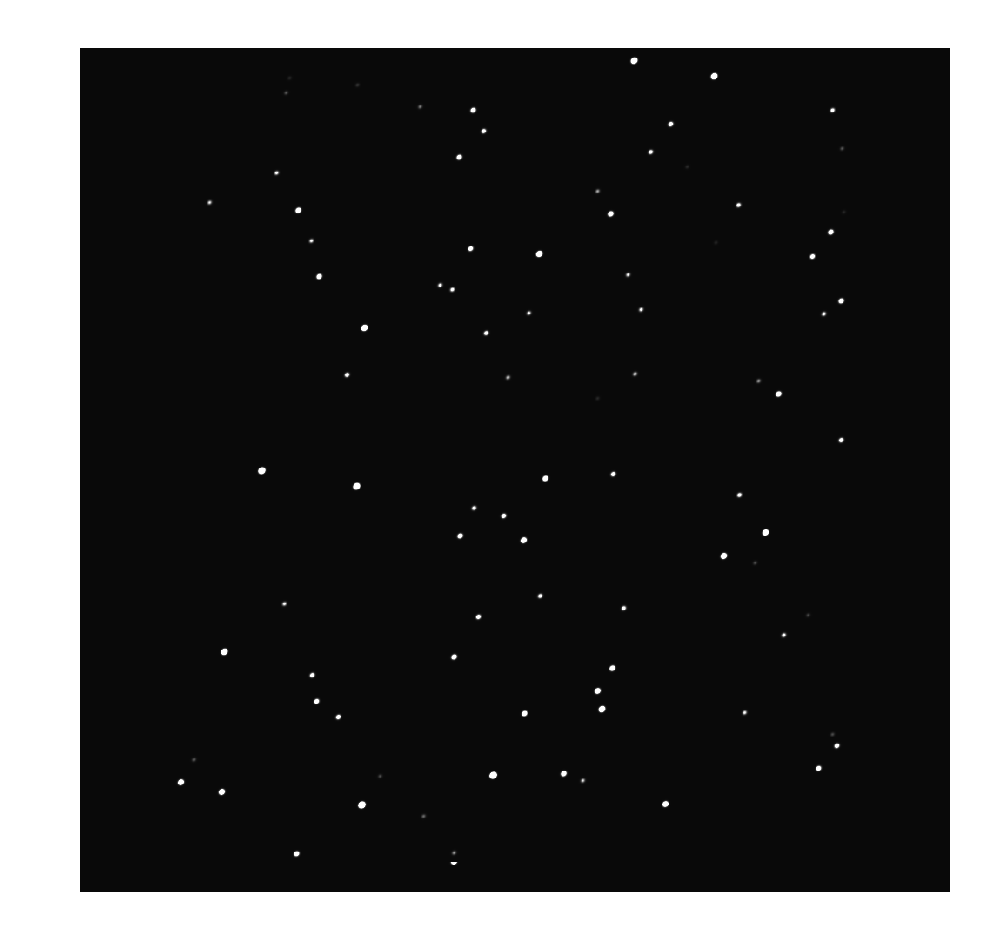

In [26]:
#fig, ax = plt.subplots()
#w, h = plt.figaspect(1.)
fig = plt.Figure(figsize=(12,12))
flat = data_sub*0.0+m
for i in range(len(df_cln)):
    try:
        xc, yc, flx = int(df_cln.y[i]), int(df_cln.x[i]), df_cln.flux[i]
        flat[xc-dw:xc+dw, yc-dw:yc+dw] = m + star_kernel*flx
    except:
        pass

im = plt.imshow(flat, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+25*s, origin='lower')

plt.ylim(0, 1000)
plt.xlim(0, 1000)
plt.axis('off')
plt.savefig('../figures/astrometry_trial_02_dffi3.png', dpi=300, bbox_inches='tight')

In [27]:
! open ../figures/